### Imports

In [1]:
import tensorflow as tf
from tensorflow.keras.layers import Dense, Lambda, Input, InputLayer, Conv2D, Conv2DTranspose, Reshape, Flatten
from tensorflow.keras.models import Model, Sequential
from tensorflow.keras.datasets import mnist
from tensorflow.keras.optimizers import Adam, RMSprop
from tensorflow.keras.losses import binary_crossentropy, mse
from tensorflow.keras.utils import plot_model
from tensorflow.keras.backend import flatten
import numpy as np
import matplotlib.pyplot as plt


### Data

In [2]:
(X_train, y_train), (X_test, y_test) = mnist.load_data()

In [3]:
X_train = X_train/255
X_test = X_test/255

img_size = 28

X_train = X_train.reshape((-1, img_size, img_size, 1 ))
X_test  = X_test.reshape((-1, img_size, img_size, 1 ))


In [4]:
batch_size = 128
train_ds = tf.data.Dataset.from_tensor_slices(X_train).shuffle(60000).batch(batch_size)
test_ds = tf.data.Dataset.from_tensor_slices(X_test).shuffle(10000).batch(batch_size)

### Model

In [5]:
class VAE(Model):

    def __init__(self, input_shape, nz):

        super(VAE, self).__init__()
        self.encoder = Sequential([
                                InputLayer(input_shape = input_shape),
                                Conv2D(filters = 16, 
                                       kernel_size = 3,
                                       activation = 'relu',
                                       strides = 2,
                                       ),
                                Flatten(),
                                Dense(16, activation = 'relu'),
                                Dense(nz+nz, activation = 'linear')

        ])

        self.decoder = Sequential([
                                   InputLayer(input_shape=(nz,)),
                                   Dense(14*14*64, activation = 'relu'),
                                   Reshape((14,14, 64)),
                                   Conv2DTranspose(filters = 16,
                                                   kernel_size = 3,
                                                   strides = 2,
                                                   padding = 'same',
                                                   activation = 'relu'),
                                   Conv2DTranspose(filters=1,
                                                   kernel_size = 3,
                                                   padding = 'same',
                                                   activation = 'sigmoid'),
                                   Reshape((28,28))
        ])

    def get_z(self, x):

        z_mean, z_log_var = tf.split(self.encoder(x), 2, axis = -1)
        return z_mean, z_log_var

    def reparameterize(self, z_mean, z_log_var):
        
        z = z_mean  + tf.random.normal(z_mean.shape) * tf.exp(z_log_var * 0.5)

        return z

    
### Creating tf graphs for computing loss and applying gradients    
    
    
@tf.function
def compute_loss(model, x):
        
        z_mean, z_log_variance = model.get_z(x)
        z = model.reparameterize(z_mean, z_log_variance)
        x_out = model.decoder(z)
        
        ## loss for maximum log likelihood
        x = tf.reshape(x, (-1, img_size*img_size))
        x_out = tf.reshape(x_out, (-1, img_size*img_size))
        loss = mse(x, x_out)
        
        loss *= 784
        
        ## using closed form of KL divergence
        kl_divergence = -0.5*tf.reduce_sum(1 + z_log_variance - 
                                           tf.square(z_mean)
                                           - tf.exp(z_log_variance), axis = 1)
        

        total_loss = loss + kl_divergence

        return tf.reduce_mean(total_loss)


@tf.function
def apply_gradients(model, x):
    
    with tf.GradientTape() as tape:
        loss = compute_loss(model, x)
    
    gradients = tape.gradient(loss, model.trainable_variables)
    opt.apply_gradients(zip(gradients, model.trainable_variables))
    
    return loss

## Training

### Utils

In [7]:
def train(model, opt, epochs):

    epoch_losses = []
    for epoch in range(epochs):

        batch_losses = []
        for train in train_ds:
            loss = apply_gradients(model, train)
            batch_losses.append(loss.numpy().mean())

        epoch_loss = np.mean(batch_losses)
        epoch_losses.append(epoch_loss)
        print('Epoch: {},  Loss: {}, '.format(epoch,epoch_loss))

In [8]:
def plot_samples_in_range(num_samples, min_val, max_val):
    
    c1 = np.linspace(min_val, max_val, num_samples)
    c2 = np.linspace(min_val, max_val, num_samples)
    np.vstack((c1, c2))
    samples = np.vstack((c1, c2)).T
    generated_out = model.decoder(samples)

    plt.figure(figsize = (10,10))

    for i, img in enumerate(generated_out.numpy()):
        plt.subplot(5,5, i+1)
        plt.imshow(img.reshape((28,28)), cmap='gray')


### Training and Output

**run the Model snippet above to create a new tf graph before running the following code snippets (has to be run before running every new model)**

In [9]:
nz = 2
input_shape = (img_size, img_size, 1)
epochs = 30

opt = Adam()
model  = VAE(input_shape, nz)

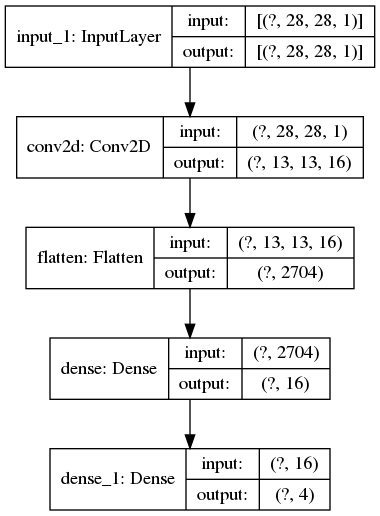

In [10]:
plot_model(model.encoder, show_shapes= True)

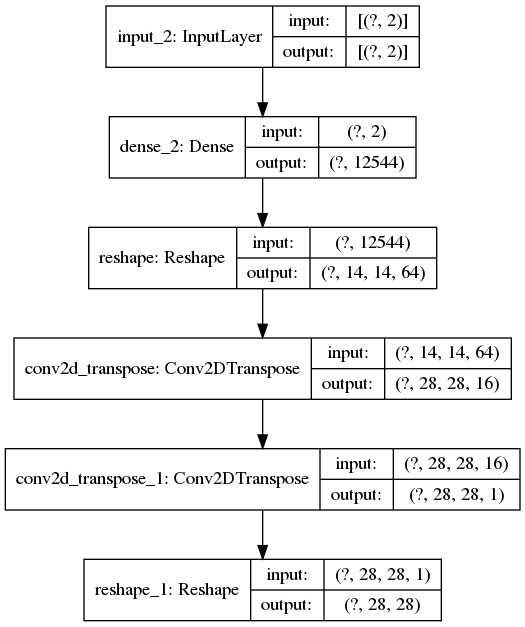

In [11]:
plot_model(model.decoder, show_shapes= True)

In [12]:
train(model, opt, epochs)


If you intended to run this layer in float32, you can safely ignore this warning. If in doubt, this warning is likely only an issue if you are porting a TensorFlow 1.X model to TensorFlow 2.

To change all layers to have dtype float64 by default, call `tf.keras.backend.set_floatx('float64')`. To change just this layer, pass dtype='float64' to the layer constructor. If you are the author of this layer, you can disable autocasting by passing autocast=False to the base Layer constructor.

Epoch: 0,  Loss: 59.19533920288086, 
Epoch: 1,  Loss: 50.03005599975586, 
Epoch: 2,  Loss: 48.627197265625, 
Epoch: 3,  Loss: 47.82196044921875, 
Epoch: 4,  Loss: 46.691078186035156, 
Epoch: 5,  Loss: 46.06594467163086, 
Epoch: 6,  Loss: 45.626060485839844, 
Epoch: 7,  Loss: 44.79355239868164, 
Epoch: 8,  Loss: 42.76753234863281, 
Epoch: 9,  Loss: 41.65769958496094, 
Epoch: 10,  Loss: 41.11936569213867, 
Epoch: 11,  Loss: 40.75405502319336, 
Epoch: 12,  Loss: 40.4567985534668, 
Epoch: 13,  Loss: 40.2223

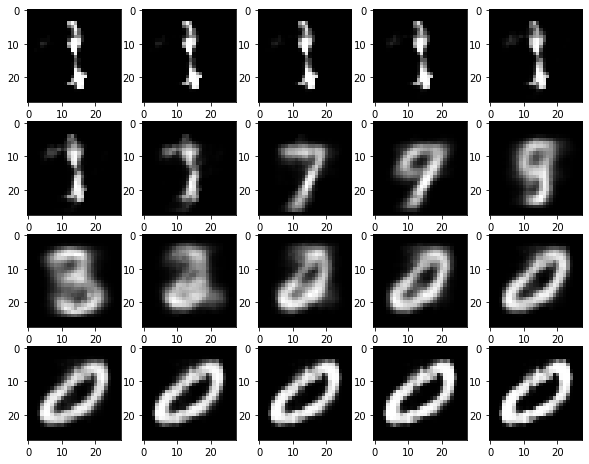

In [17]:
plot_samples_in_range(20, -4, 4)